Dataset link : https://www.kaggle.com/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing

Loading Dependencies

In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
from librosa.core import resample
import librosa
import numpy as np

from keras.models import Sequential
from keras.layers import Conv2D,Dense,Flatten

Build Data Loading Function

In [101]:
# Define paths to file

ROOT_PATH = r"D:\Datasets\Bird Voice Dataset"
CAPUCHIN_PATH = os.path.join(ROOT_PATH,"Parsed_Capuchinbird_Clips")
CAPUCHIN_PATH_ONE = r"D:\Datasets\Bird Voice Dataset\Parsed_Capuchinbird_Clips\XC3776-3.wav"
NOT_CAPUCHIN_PATH_ONE = r"D:\Datasets\Bird Voice Dataset\Parsed_Not_Capuchinbird_Clips\afternoon-birds-song-in-forest-0.wav"
NOT_CAPUCHIN_PATH = os.path.join(ROOT_PATH,"Parsed_Not_Capuchinbird_Clips")

In [102]:
# Function

def load_audio_data(filename):
    wav,sample_rate = librosa.load(filename,mono=True)   # load .wav file
    wav = np.squeeze(wav)  # remove trailing axis
    wav = resample(wav,orig_sr=sample_rate,target_sr=16000) # resampling the wave to 16khz
    wav = tf.constant(wav)
    return wav

In [103]:
pdata = load_audio_data(CAPUCHIN_PATH_ONE)
ndata = load_audio_data(NOT_CAPUCHIN_PATH_ONE)

Plotting Wave

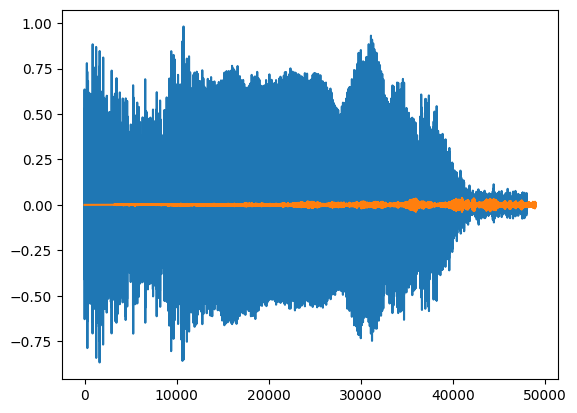

In [104]:
plt.plot(pdata)
plt.plot(ndata)
plt.show()

# here the blue wave is capuchin birds

Creating Dataset

In [105]:
pos = tf.data.Dataset.list_files(CAPUCHIN_PATH + '\*.wav')
neg = tf.data.Dataset.list_files(NOT_CAPUCHIN_PATH + '\*.wav')

In [106]:
pos.as_numpy_iterator().next()

b'D:\\Datasets\\Bird Voice Dataset\\Parsed_Capuchinbird_Clips\\XC98557-1.wav'

In [107]:
positive = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negative = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positive.concatenate(negative)

Determining the average length of Capuchin Call

In [108]:
# Calculating Wave Length

lengths = []

for file in os.listdir(CAPUCHIN_PATH):
    tensor_wave = load_audio_data(os.path.join(CAPUCHIN_PATH,file))
    lengths.append(len(tensor_wave))

In [109]:
# Calculating mean, min and max

tf.math.reduce_mean(lengths)
tf.math.reduce_min(lengths)
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

Building Preprocessing function to convert to Spectrogram

In [110]:
def preprocess(file_path,label):
    file_path = file_path.numpy().decode('utf-8')  # Convert bytes tensor to string
    wav = load_audio_data(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding,wav],0)

    '''Fourier transformation is used here to extract various frequencies from a wave.
    #When you apply Fourier transform to a wave, it decomposes the wave into its constituent frequency components. 
    Each frequency component represents a specific oscillation or vibration within the wave.'''
    
    spectrogram = tf.signal.stft(wav,frame_length=320, frame_step=32)   # stft short time fourier transform    
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram,axis=2)
    print(type(spectrogram),type(label))
    return spectrogram,label

In [111]:
def preprocess_tf(file_path, label):
    spectrogram, label = tf.py_function(preprocess, [file_path, label], [tf.float32, tf.float32])
    return spectrogram, label

In [112]:
file_path,label = positive.shuffle(buffer_size=100000).as_numpy_iterator().next()

In [113]:
spectrogram, label = preprocess_tf(file_path,label)

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


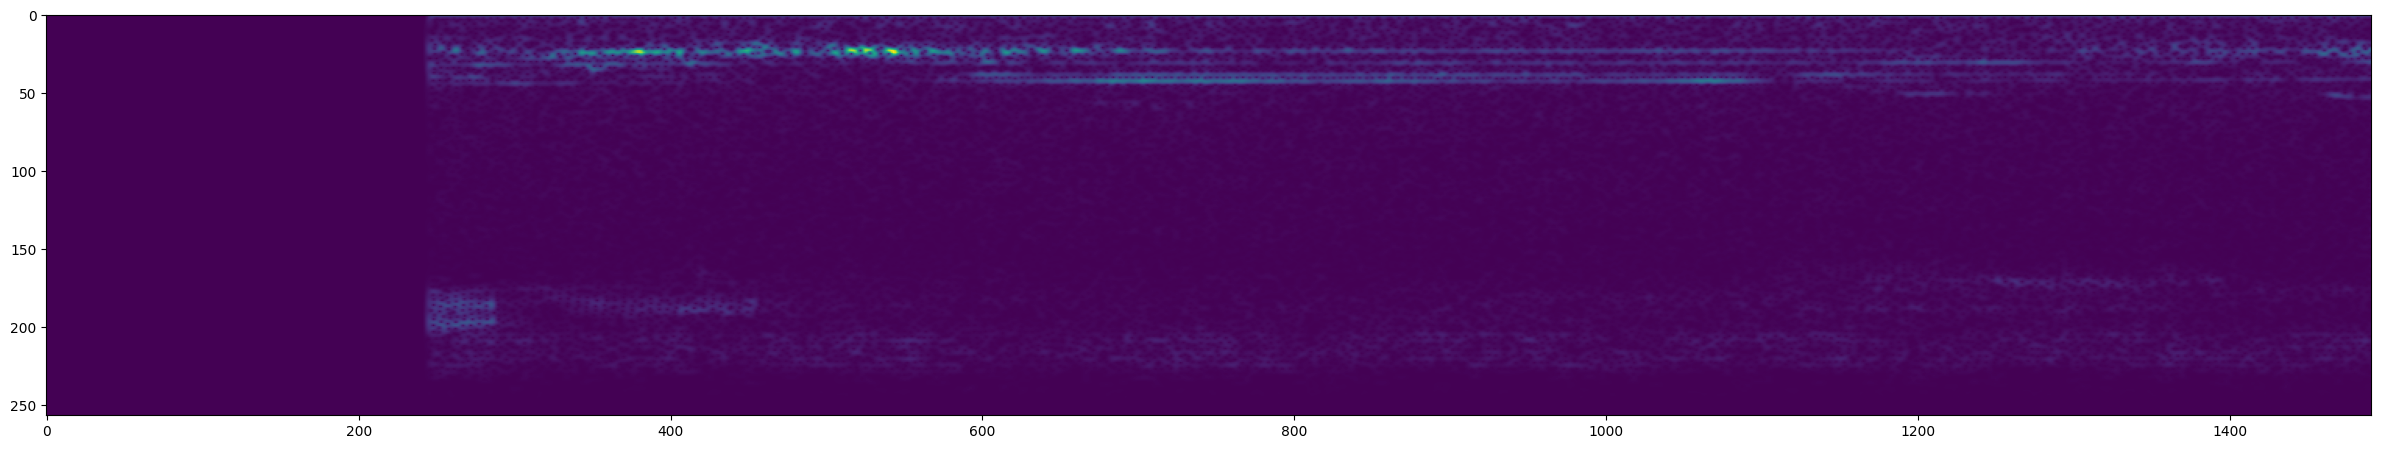

In [114]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

Creating tensorflow data pipeline

In [115]:
data.as_numpy_iterator().next()

(b'D:\\Datasets\\Bird Voice Dataset\\Parsed_Capuchinbird_Clips\\XC3776-4.wav',
 1.0)

In [116]:
data = data.map(preprocess_tf)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

Splitting data into training and testing Partition

In [117]:
len(data)

51

In [118]:
train = data.take(36)
test = data.skip(36).take(15)

In [120]:
samples,labels = train.as_numpy_iterator().next()

In [134]:
model = Sequential()

model.add(Conv2D(16,(3,3),activation='relu',input_shape=(1491,257,1)))
model.add(Conv2D(16,(3,3),activation='relu'))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [135]:
model.compile(optimizer='Adam',loss="BinaryCrossentropy",metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [136]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 1489, 255, 16)     160       
                                                                 
 conv2d_5 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten_2 (Flatten)         (None, 6019376)           0         
                                                                 
 dense_3 (Dense)             (None, 128)               770480256 
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770482865 (-1213035836.00 Byte)
Trainable params: 770482865 (-1213035836.00 Byte)
Non-trainable params: 0 (0.00 Byte)
______________________________________________________

c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\layer_utils.py:146: RuntimeWarning: overflow encountered in scalar multiply
  total_memory_size += weight_shape * per_param_size


In [137]:
hist = model.fit(train,epochs=10,validation_data=test)

Epoch 1/10
 1/36 [..............................] - ETA: 1:03:52 - loss: 0.6806 - recall_2: 0.5000 - precision_2: 0.1667